# DICS for power mapping

- Author: Marijn van Vliet <w.m.vanvliet@gmail.com>
- License: BSD-3-Clause
- Copyright the MNE-Python contributors.

### Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import coherence, unit_impulse, welch

import mne
from mne.beamformer import apply_dics_csd, make_dics
from mne.datasets import sample, eegbci, fetch_fsaverage
from mne.minimum_norm import apply_inverse, make_inverse_operator, read_inverse_operator
from mne.simulation import add_noise, simulate_raw
from mne.time_frequency import csd_morlet

# We use the MEG and MRI setup from the MNE-sample dataset
data_path = sample.data_path(download=False)
# subjects_dir = data_path / "subjects"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir

# Filenames for various files we'll be using
# meg_path = data_path / "MEG" / "sample"
# raw_fname = meg_path / "sample_audvis_raw.fif"
# fwd_fname = meg_path / "sample_audvis-eeg-oct-6-fwd.fif"
fwd_fname = './test-fwd.fif'
# cov_fname = meg_path / "sample_audvis-cov.fif"
fwd = mne.read_forward_solution(fwd_fname)

# Seed for the random number generator
rand = np.random.RandomState(42)

0 files missing from root.txt in C:\Users\user\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\user\mne_data\MNE-fsaverage-data\fsaverage
Reading forward solution from g:\共用雲端硬碟\CNElab_陳昱祺\source localization\test-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (20484 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


c:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


###  Data simulation

In [2]:
sfreq = 100.0  # Sampling frequency of the generated signal
n_samp = int(round(2.0 * sfreq))
times = np.arange(n_samp) / sfreq  # 10 seconds of signal
n_times = len(times)


def coh_signal_gen(base_freq=10.0, magnitude= 20e-9):
    """Generate an oscillating signal.

    Returns
    -------
    signal : ndarray
        The generated signal.
    """
    t_rand = 0.001  # Variation in the instantaneous frequency of the signal
    std = 0.1  # Std-dev of the random fluctuations added to the signal
    # base_freq = 10.0  # Base frequency of the oscillators in Hertz
    n_times = len(times)

    # Generate an oscillator with varying frequency and phase lag.
    signal = np.sin(
        2.0
        * np.pi
        * (
            base_freq * np.arange(n_times) / sfreq
            + np.cumsum(t_rand * rand.randn(n_times))
        )
    )

    # Add some random fluctuations to the signal.
    signal += std * rand.randn(n_times)

    # Scale the signal to be in the right order of magnitude (~100 nAm)
    # for MEG data.
    signal *= magnitude  #20e-9

    return signal

### Signal GEN

In [3]:
signal1 = coh_signal_gen(22)
signal2 = coh_signal_gen(3)
signal3 = coh_signal_gen(12)
signal4 = coh_signal_gen(16)
signal5 = coh_signal_gen(11)

# The locations on the cortex where the signal will originate from. These
# locations are indicated as vertex numbers.
vertices = [[198, 1981], [825, 975, 1363]]

# label:posteriorcingulate-rh, index:47, vertices:79988, freq=16
# label:paracentral-lh, index:32, vertices:47462, freq=22
# label:supramarginal-lh, index:62, vertices:58011, freq=3
# label:caudalmiddlefrontal-rh, index:5, vertices:100939, freq=11
# label:entorhinal-lh, index:8, vertices:117410, freq=12



In [4]:

# fig, axes = plt.subplots(2, 2, figsize=(8, 4), layout="constrained")

# # Plot the timeseries
# ax = axes[0][0]
# ax.plot(times, 1e9 * signal1, lw=0.5)
# ax.set(
#     xlabel="Time (s)", xlim=times[[0, -1]], ylabel="Amplitude (Am)", title="Signal 1"
# )
# ax = axes[0][1]
# ax.plot(times, 1e9 * signal2, lw=0.5)
# ax.set(xlabel="Time (s)", xlim=times[[0, -1]], title="Signal 2")

# # Power spectrum of the first timeseries
# f, p = welch(signal1, fs=sfreq, nperseg=128, nfft=256)
# ax = axes[1][0]
# # Only plot the first 100 frequencies
# ax.plot(f[:100], 20 * np.log10(p[:100]), lw=1.0)
# ax.set(
#     xlabel="Frequency (Hz)",
#     xlim=f[[0, 99]],
#     ylabel="Power (dB)",
#     title="Power spectrum of signal 1",
# )

# # Compute the coherence between the two timeseries
# f, coh = coherence(signal1, signal2, fs=sfreq, nperseg=100, noverlap=64)
# ax = axes[1][1]
# ax.plot(f[:50], coh[:50], lw=1.0)
# ax.set(
#     xlabel="Frequency (Hz)",
#     xlim=f[[0, 49]],
#     ylabel="Coherence",
#     title="Coherence between the timeseries",
# )

In [5]:
# # The locations on the cortex where the signal will originate from. These
# # locations are indicated as vertex numbers.
# vertices = [[146374], [83169]]

# Construct SourceEstimates that describe the signals at the cortical level.
data = np.vstack((signal1, signal2, signal3, signal4, signal5))
stc_signal = mne.SourceEstimate(
    data, vertices, tmin=0, tstep=1.0 / sfreq, subject="sample"
)
stc_noise = stc_signal * 0.0

snr = 20.0  # Signal-to-noise ratio. Decrease to add more noise.

In [6]:
stc_signal.vertices

[array([ 198, 1981], dtype=int64), array([ 825,  975, 1363], dtype=int64)]

In [7]:
# 取得每個 hemisphere 的 vertex index
all_vertices = [s['vertno'] for s in fwd['src']]  # 這是一個長度為2的list: [lh_vertices, rh_vertices]

# 建立全 0 的資料，shape = (n_vertices_total, n_times)
n_lh = len(all_vertices[0])
n_rh = len(all_vertices[1])

n_times = 200
data_lh = np.zeros((n_lh, n_times))
data_rh = np.zeros((n_rh, n_times))
data_lh = np.random.normal(0, 0.1, (n_lh, n_times)) * 20e-10  # Gaussian noise
data_rh = np.random.normal(0, 0.1, (n_rh, n_times)) * 20e-10  # Gaussian noise

# 將 5 個信號填入指定位置
# 根據你給的 vertices 為例:
signal_list = [[signal1, signal2],[signal3, signal4, signal5]]
vertices = [[198, 1981], [825, 975, 1363]]

for i in range(len(vertices[0])):
    idx = all_vertices[0].tolist().index(vertices[0][i])
    data_lh[idx, :] = signal_list[0][i]

for i in range(len(vertices[1])):
    idx = all_vertices[1].tolist().index(vertices[1][i])
    data_lh[idx, :] = signal_list[1][i]

data = np.concatenate([data_lh, data_rh])
# print(data.shape, n_lh, n_rh)

# 建立 SourceEstimate
stc_signal = mne.SourceEstimate(
    data, all_vertices, tmin=0, tstep=1.0 / sfreq, subject="sample"
)


In [ ]:
labels[0].he

'lh'

In [8]:
# 讀入 label（list of mne.Label objects）
labels = mne.read_labels_from_annot(subject="", subjects_dir=subjects_dir)

# 從 forward model 拿到 surface vertex index（source space）
lh_surf_vertices = fwd["src"][0]["vertno"]
rh_surf_vertices = fwd["src"][1]["vertno"]

# 從所有 labels 中收集 LH / RH 的 vertex index
lh_label_vertices = np.concatenate([label.vertices for label in labels if label.hemi == 'lh'])
rh_label_vertices = np.concatenate([label.vertices for label in labels if label.hemi == 'rh'])

# 求出未被涵蓋的 vertex：in surf_vertices but not in any label
lh_unlabeled = np.setdiff1d(lh_surf_vertices, lh_label_vertices)
rh_unlabeled = np.setdiff1d(rh_surf_vertices, rh_label_vertices)

# 顯示結果
print(f"LH 未被任何 label 涵蓋的 vertices 數量: {len(lh_unlabeled)}")
print(f"RH 未被任何 label 涵蓋的 vertices 數量: {len(rh_unlabeled)}")

# （可選）查看具體 index
# print("LH unlabeled vertices:", lh_unlabeled)
# print("RH unlabeled vertices:", rh_unlabeled)



Reading labels from parcellation...
   read 35 labels from C:\Users\user\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\user\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
LH 未被任何 label 涵蓋的 vertices 數量: 870
RH 未被任何 label 涵蓋的 vertices 數量: 872


In [ ]:
# subject = "sample"
# subjects_dir = data_path / "subjects"

# # 取得左右半球 vertices
# lh_surf_vertices = fwd["src"][0]["vertno"]
# rh_surf_vertices = fwd["src"][1]["vertno"]

# # 取得所有 label 中的 vertices
# lh_label_vertices = np.concatenate([label.vertices for label in labels if label.hemi == 'lh'])
# rh_label_vertices = np.concatenate([label.vertices for label in labels if label.hemi == 'rh'])

# # 找出未被覆蓋的 vertices
# lh_unlabeled = np.setdiff1d(lh_surf_vertices, lh_label_vertices)
# rh_unlabeled = np.setdiff1d(rh_surf_vertices, rh_label_vertices)

# # 建立一個 SourceEstimate 並將未標到的位置設為 1
# n_times = 1
# data_lh = np.zeros((len(lh_surf_vertices), n_times))
# data_rh = np.zeros((len(rh_surf_vertices), n_times))

# # 找出未標點在 source space 中的 index（注意是 fwd['src'] 中的 vertno 的位置）
# lh_indices = np.searchsorted(lh_surf_vertices, lh_unlabeled)
# rh_indices = np.searchsorted(rh_surf_vertices, rh_unlabeled)

# data_lh[lh_indices, 0] = 1.0
# data_rh[rh_indices, 0] = 1.0

# # 組合成一個 SourceEstimate
# stc = mne.SourceEstimate(
#     data=np.vstack([data_lh, data_rh]),
#     vertices=[lh_surf_vertices, rh_surf_vertices],
#     tmin=0, tstep=1.0, subject=subject
# )

# # 畫出來
# brain = stc.plot(subject=subject, subjects_dir=subjects_dir,
#                  hemi='both', time_viewer=False, time_unit='s',
#                  initial_time=0, size=(800, 600), background='white',
#                  clim=dict(kind='value', lims=[0.5, 0.75, 1.0]),
#                  smoothing_steps=5)

Using pyvistaqt 3d backend.



In [ ]:
# Read the info from the sample dataset. This defines the location of the
# sensors and such.
# info = mne.io.read_raw(raw_fname).crop(0, 1).resample(100).info
(raw_fname,) = eegbci.load_data(subject=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)
raw.resample(sfreq = 100.0)
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name, ch_name.rstrip(".").upper().replace("Z", "z").replace("FP", "Fp"))
    for ch_name in raw.ch_names
)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

info = raw.info

# Only use gradiometers
# picks = mne.pick_types(info, meg="grad", stim=True, exclude=())
# mne.pick_info(info, picks, copy=False)  # modifies info in-place
picks = mne.pick_types(info, eeg=True, stim=True, exclude=())
mne.pick_info(info, picks, copy=False)  # modifies info in-place

# Define a covariance matrix for the simulated noise. In this tutorial, we use
# a simple diagonal matrix.
cov = mne.cov.make_ad_hoc_cov(info)
cov["data"] *= (20.0 / snr) ** 2  # Scale the noise to achieve the desired SNR

# Simulate the raw data, with a lowpass filter on the noise
stcs = [
    (stc_signal, unit_impulse(n_samp, dtype=int) * 1),
    (stc_noise, unit_impulse(n_samp, dtype=int) * 2),
]  # stacked in time
duration = (len(stc_signal.times) * 2) / sfreq
raw = simulate_raw(info, stcs, forward=fwd)
add_noise(raw, cov, iir_filter=[4, -4, 0.8], random_state=rand)

In [ ]:
# events = mne.find_events(raw, initial_event=True)
events = np.array([[  0,   0,   1],
                  [500,   0,   2]])
tmax = (len(stc_signal.times) - 1) / sfreq
epochs = mne.Epochs(
    raw,
    events,
    event_id=dict(signal=1, noise=2),
    tmin=0,
    tmax=tmax,
    baseline=None,
    preload=True,
)
assert len(epochs) == 2  # ensure that we got the two expected events

# Plot some of the channels of the simulated data that are situated above one
# of our simulated sources.
# Choose EEG channels instead of MEG gradiometers
picks = mne.pick_types(epochs.info, eeg=True, exclude="bads")  # Select only EEG channels

# Plot selected EEG channels
epochs.plot(picks=picks, events=True)

### Power Mapping

In [ ]:
epochs.set_eeg_reference("average", projection=True)

# Compute the inverse operator
# fwd = mne.read_forward_solution(fwd_fname)

# fname_inv = data_path / "MEG" / "sample" / "sample_audvis-eeg-oct-6-eeg-inv.fif"
# inv = read_inverse_operator(fname_inv)
inv = make_inverse_operator(epochs.info, fwd, cov)


# Apply the inverse model to the trial that also contains the signal.
s = apply_inverse(epochs["signal"].average(), inv, method="eLORETA", pick_ori="normal")

# Take the root-mean square along the time dimension and plot the result.
s_rms = np.sqrt((s**2).mean())
title = "MNE-dSPM inverse (RMS)"
brain = s.plot(
    # "sample",
    # subjects_dir=subjects_dir,
    hemi="both",
    figure=1,
    size=600,
)

# Indicate the true locations of the source activity on the plot.
# brain.add_foci(vertices[0][0], coords_as_verts=True, hemi="lh")
# brain.add_foci(vertices[1][0], coords_as_verts=True, hemi="rh")

# Rotate the view and add a title.
brain.show_view(azimuth=0, elevation=0, distance=550, focalpoint=(0, 0, 0))

### Source PCA

In [23]:
labels = mne.read_labels_from_annot("", subjects_dir=subjects_dir)
labels = labels[:-1]


Reading labels from parcellation...
   read 35 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot


In [ ]:
import numpy as np
import mne
from sklearn.decomposition import PCA

# 取得 stc_gen 內的數據 (6940, 100)
stc_data = stc_signal.data  # shape: (6940, 100)
print(stc_data.shape)

# 初始化 PCA
pca = PCA(n_components=1)  # 取前 3 個主成分

# 儲存降維後的信號
pca_time_series = []
# labels = mne.read_labels_from_annot("sample", subjects_dir=subjects_dir)

# 針對每個 label 進行 PCA
for label in labels:
    # 獲取當前 label 內的頂點索引
    label_vertices = np.intersect1d(label.vertices, np.concatenate(stc_signal.vertices))

    # 若 label 內沒有任何有效頂點，跳過
    # print(label)
    # if len(label_vertices) == 0:
    #     pca_time_series.append(np.zeros((3, 100)))  # 空的填充
    #     continue

    # 找出 stc_gen 內對應的 index
    label_idx = np.where(np.isin(np.concatenate(stc_signal.vertices), label_vertices))[0]
    # print(label)
    # print(label_idx)

    # 取出該 label 內的 source time courses
    label_data = stc_data[label_idx, :]  # shape: (N_label_vertices, 100)

    # 使用 PCA 進行降維，取前 3 個主成分
    pca_result = pca.fit_transform(label_data.T).T  # shape: (3, 100)

    # 存入結果
    pca_time_series.append(pca_result)

# 轉換成 NumPy 陣列
pca_time_series = np.vstack(pca_time_series)  # shape: (68×3, 100)

# 輸出最終形狀
pca_time_series.shape  # 期望結果: (68*3, 100)


(20484, 200)
<Label | , 'bankssts-lh', lh : 2137 vertices>
[  129   133   289   290   556   557   558   559   768   769   770   968
  1225  1226  1227  1228  1229  1230  1231  1232  1233  1234  1236  1672
  1673  1674  1675  1676  1677  2311  2312  2313  2314  2315  2316  2688
  2690  3145  3146  3147  3148  3149  3150  3151  3152  3153  3154  3155
  3156  3745  3746  3747  3748  3749  3750  3751  3752  3753  3754  3755
  3756  5118  5125  5131  5132  5133  5134  5135  5136  5137  5138  5139
  5140  5141  5142  5143  5144  5145  5146  5992  5993  5994  5995  5996
  6350  6813  6814  6815  6816  6817  6818  6819  6820  6821  6822  6823
  6824  6825  6826  6827  6828  6829  6830  6831  6832  6833  7742  7743
  7744  7745  7746  7747  7748  7749  7750  7751  7752  7753  7754  7755
  9489  9490  9491  9492  9493  9494  9495  9496  9497  9498  9499  9500
  9501  9502 10371 10375 10531 10532 10798 10799 10800 10801 11010 11011
 11012 11210 11467 11468 11469 11470 11471 11472 11473 11474 1147

(68, 200)

### FFT

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 假設你的降維數據是 (68, 100)，這裡用隨機數據替代
source_data = pca_time_series

# 設定 FFT 參數
sampling_rate = 100  # 假設取樣率為 100 Hz

# 計算 FFT
fft_result = np.fft.fft(source_data, axis=1)
power_spectrum = np.abs(fft_result) ** 2

# 計算頻率軸
freqs = np.fft.fftfreq(source_data.shape[1], d=1/sampling_rate)

# 只取正頻率部分
positive_freqs = freqs[:source_data.shape[1] // 2]
positive_power = power_spectrum[:, :source_data.shape[1] // 2]



### Plot FFT

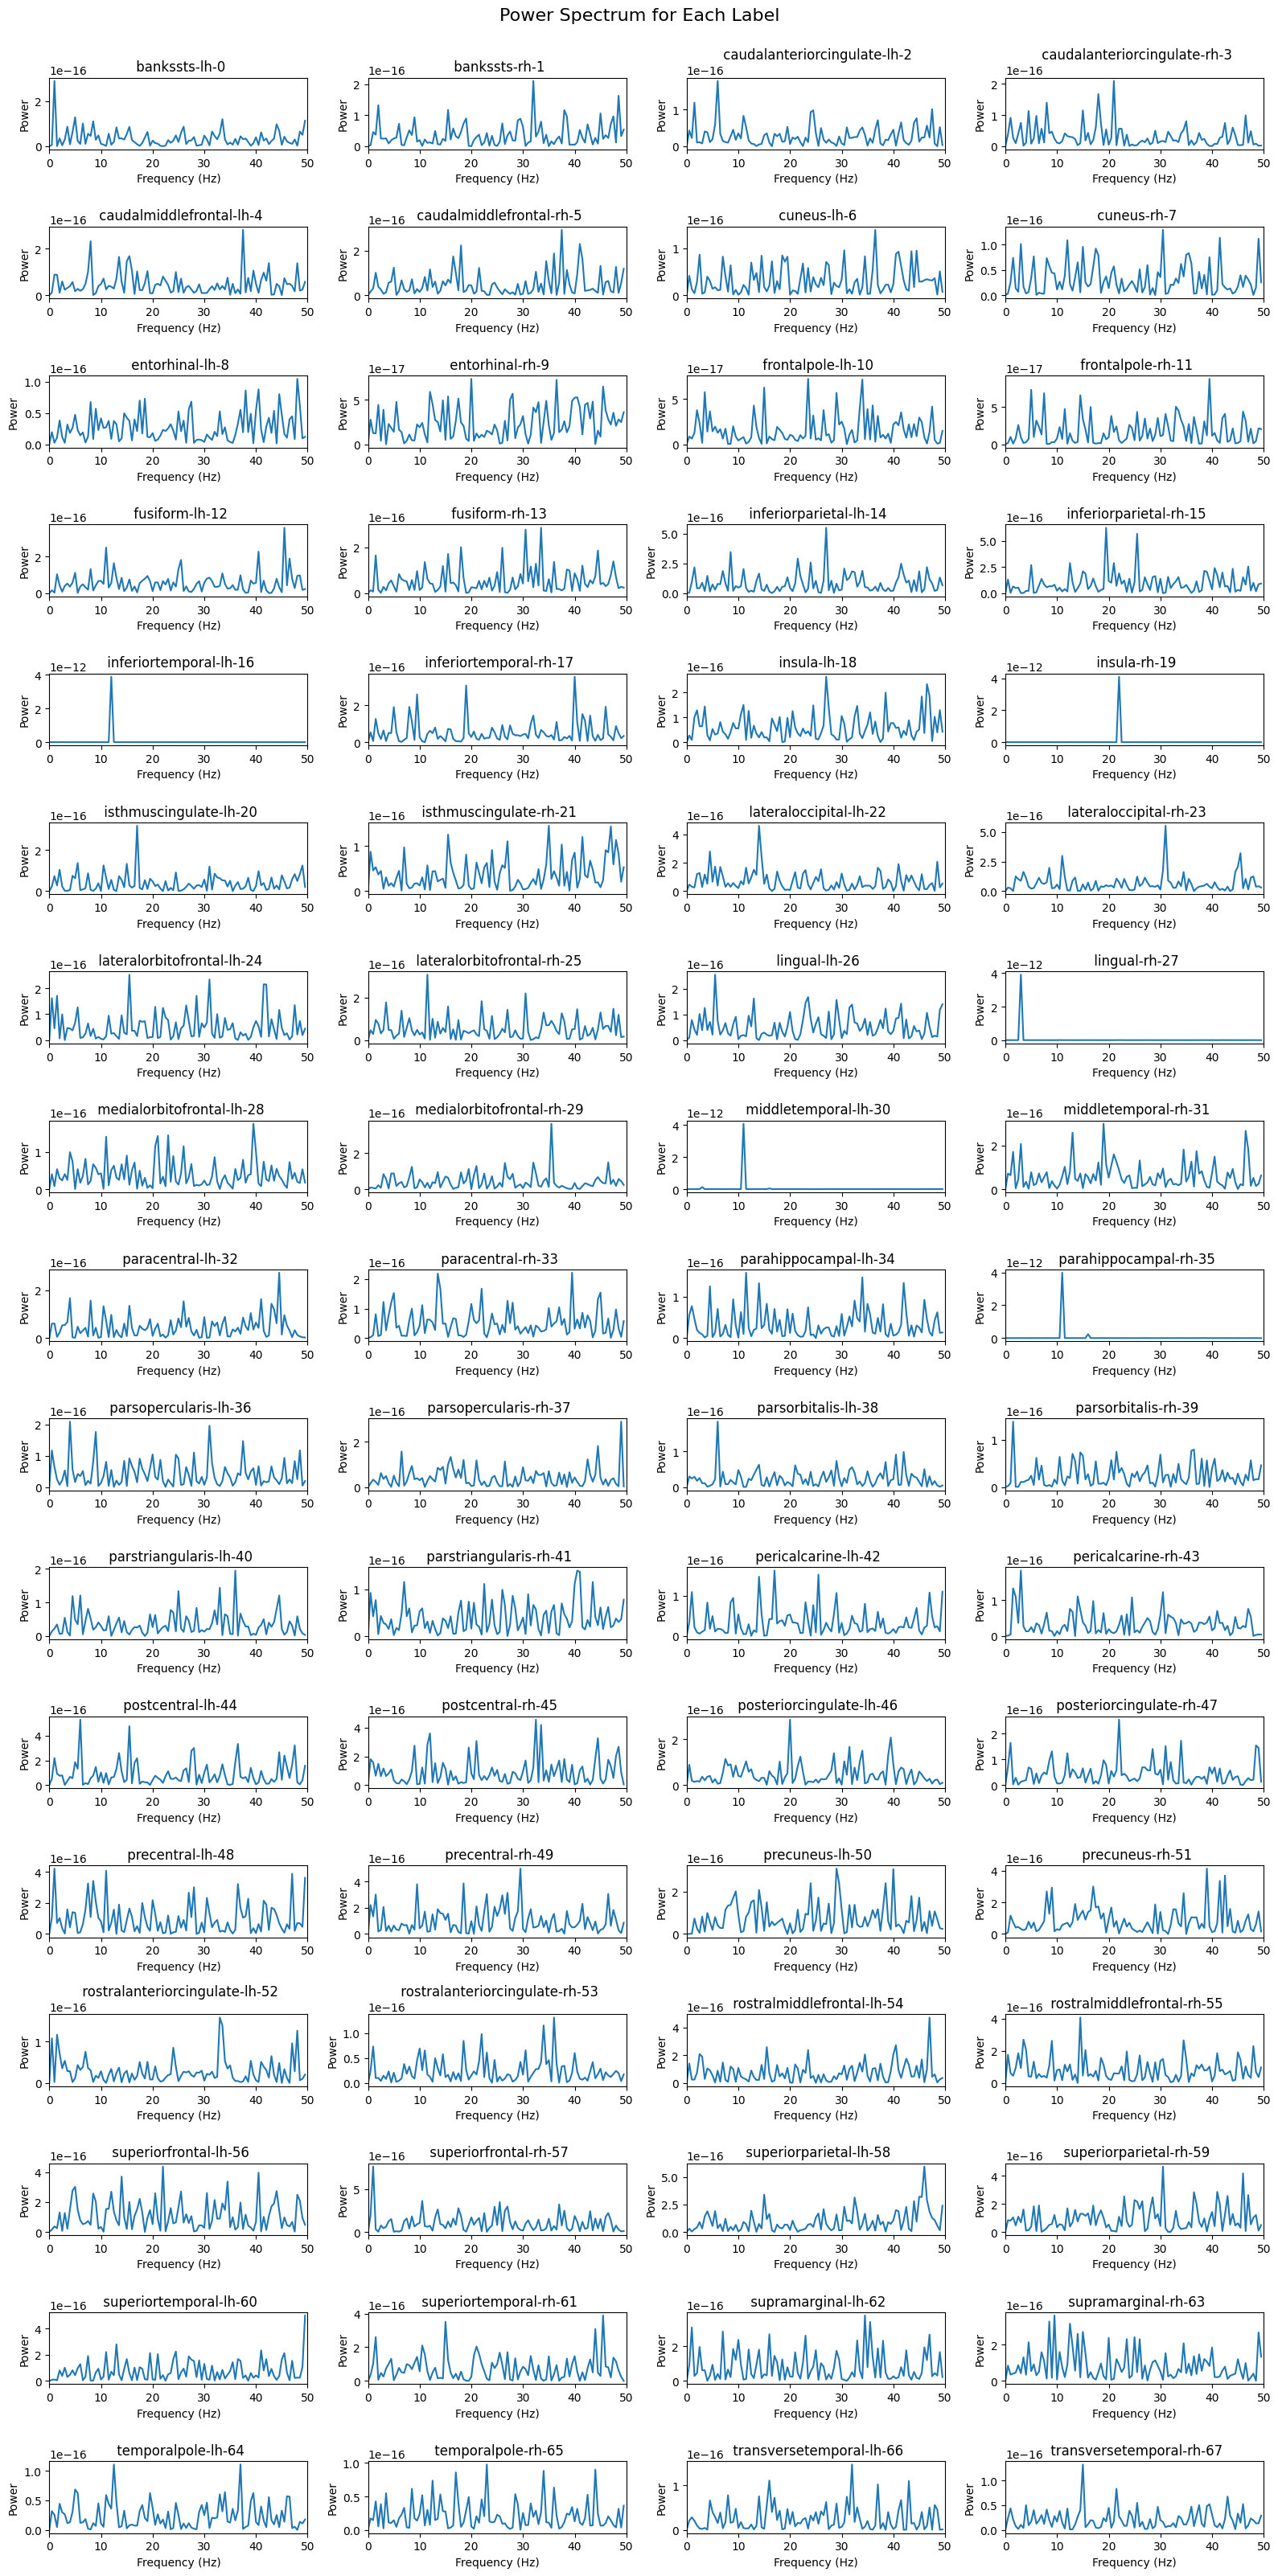

In [32]:
# 畫出所有 labels 的 Power Spectrum
fig, axes = plt.subplots(17, 4, figsize=(16, 32))  # 8x9 網格排布 (68 個 labels)
fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)

for i, ax in enumerate(axes.flat):
    if i < 68:
        ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
        ax.set_title(f' {labels[i].name}-{i}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
        ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
    else:
        ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
plt.show()


### PLot Sim Source FFT

In [ ]:
# 檢查 simulated source 正確

def do_fft(signals, sampling_rate = 100):

    # 計算 FFT
    stc_fft = np.fft.fft(signals, axis=1)
    stc_power_spectrum = np.abs(stc_fft) ** 2

    # 計算頻率軸
    freqs = np.fft.fftfreq(signals.shape[1], d=1/sampling_rate)

    # 只取正頻率部分
    positive_freqs = freqs[:signals.shape[1] // 2]
    positive_power = stc_power_spectrum[:, :signals.shape[1] // 2]

    return positive_power, positive_freqs

def show_fft(positive_power, positive_freqs, x, y, z):
    # 畫出所有 labels 的 Power Spectrum
    fig, axes = plt.subplots(x, y, figsize=(16, z))  
    fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)

    for i, ax in enumerate(axes.flat):
        if i < len(positive_power):
            ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
            ax.set_title(f' Channel-{i}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
        else:
            ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

    plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
    plt.show()

stc_positive_power, stc_positive_freqs = do_fft(stc_signal.data)
show_fft(stc_positive_power, stc_positive_freqs, 3, 4, 8)

In [ ]:
eeg = epochs.get_data(picks)
eeg = raw.get_data(picks)
print(eeg.shape)
signals = eeg[0]
nosie = eeg[1]

eeg_positive_power, eeg_positive_freqs = do_fft(eeg)
show_fft(eeg_positive_power, eeg_positive_freqs, 24, 4, 32)

In [54]:
import torch

# 假設你的資料大小
batch = 2
source = 2
psd = 2

# 隨機整數資料，值介於 0 到 9（不含 10）
data = torch.randint(low=0, high=10, size=(batch, source, psd), dtype=torch.float32)
print("原始資料 (data):\n", data)

# 查看不同維度上的 mean
print("\n整體 mean (dim=None):\n", data.mean())
print("\n", data - data.mean())

print("\n沿著 dim=0 (batch 維) 計算 mean:\n", data.mean(dim=0, keepdim=True))
print("\n", data - data.mean(dim=0, keepdim=True))

print("\n沿著 dim=1 (source 維) 計算 mean:\n", data.mean(dim=1, keepdim=True))
print("\n", data - data.mean(dim=1, keepdim=True))

print("\n沿著 dim=2 (PSD 維) 計算 mean:\n", data.mean(dim=2, keepdim=True))
print("\n", data - data.mean(dim=2, keepdim=True))

print("\n沿著 dim=(1,2) (每個 sample 的 source+PSD mean):\n", data.mean(dim=(1, 2), keepdim=True))
print("\n", data - data.mean(dim=(1, 2), keepdim=True))

print("\n沿著 dim=(0,1,2) 全域 mean:\n", data.mean(dim=(0, 1, 2), keepdim=True))
print("\n", data - data.mean(dim=(0, 1, 2), keepdim=True))


原始資料 (data):
 tensor([[[2., 3.],
         [2., 4.]],

        [[7., 2.],
         [1., 0.]]])

整體 mean (dim=None):
 tensor(2.6250)

 tensor([[[-0.6250,  0.3750],
         [-0.6250,  1.3750]],

        [[ 4.3750, -0.6250],
         [-1.6250, -2.6250]]])

沿著 dim=0 (batch 維) 計算 mean:
 tensor([[[4.5000, 2.5000],
         [1.5000, 2.0000]]])

 tensor([[[-2.5000,  0.5000],
         [ 0.5000,  2.0000]],

        [[ 2.5000, -0.5000],
         [-0.5000, -2.0000]]])

沿著 dim=1 (source 維) 計算 mean:
 tensor([[[2.0000, 3.5000]],

        [[4.0000, 1.0000]]])

 tensor([[[ 0.0000, -0.5000],
         [ 0.0000,  0.5000]],

        [[ 3.0000,  1.0000],
         [-3.0000, -1.0000]]])

沿著 dim=2 (PSD 維) 計算 mean:
 tensor([[[2.5000],
         [3.0000]],

        [[4.5000],
         [0.5000]]])

 tensor([[[-0.5000,  0.5000],
         [-1.0000,  1.0000]],

        [[ 2.5000, -2.5000],
         [ 0.5000, -0.5000]]])

沿著 dim=(1,2) (每個 sample 的 source+PSD mean):
 tensor([[[2.7500]],

        [[2.5000]]])

 tensor([